In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 128,    #Numero di campioni elaborati in un singolo batch.
    "n_workers": 2,       #Processi del DataLoader che pre-caricano i dati in parallelo.
    "max_seq_len": 1024,  #Lunghezza massima (token): i testi più lunghi verranno troncati.
                          #Quelli più corti verranno riempiti con il token <pad>.

    # PARAMETRI DEL MODELLO:
    "embedding_dim": 128,   #Dimensione dei vettori di embedding (spazio semantico dei token).
    "hidden_dim": 128,      #Neuroni del layer nascosto dell’MLP.
    "output_dim": 2,        #Dimensione dell’output: 2 classi --> 0 = Human , 1 = GenAI.

     # PARAMETRI DI TRAINING:
    "learning_rate": 8e-4,    #Tasso di apprendimento dell’ottimizzatore (es. Adam).
    "epochs": 12,             #Numero di epoche: quante volte l’intero dataset viene visto dal modello.

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE:
    "val_size": 0.2,            #Frazione di split per validazione (hold-out del 20%).
    "dropout": 0.2,             #Probabilità di spegnimento neuroni a train-time (keep probability q=0.8).
    "weight_decay": 2e-4,       #Penalità L2 per controllare l'overfitting.
    "label_smoothing": 0.02,    #Smoothing del target (per K=2: [0.98, 0.02] sul vettore obiettivo).
    "patience": 4               #Early stopping se la val-loss non migliora per 4 epoche consecutive.
}

In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core + dataset + mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report                                 #Report testuale riassuntivo per classe e aggregati.
)

In [ ]:
# --- DEVICE & A100 SETUP -----------------------------------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    name = torch.cuda.get_device_name(0)
    cap  = torch.cuda.get_device_capability(0)  # (major, minor) → A100 = (8,0)
    print(f"[LOG] Device → cuda:0 | GPU: {name} | CC: {cap} | CUDA: {torch.version.cuda} | Torch: {torch.__version__}")

    # Sblocca TensorFloat-32 su Ampere+ (A100): velocizza matmul/conv mantenendo precisione FP32 accettabile
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    # Suggerisci a PyTorch di usare kernel a precisione più alta per i matmul FP32
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

    # Su Ampere (CC >= 8) usiamo AMP in **bfloat16** (niente GradScaler necessario)
    USE_BF16 = cap[0] >= 8
    AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16
else:
    print(f"[LOG] Device → cpu | Torch: {torch.__version__}")
    USE_BF16  = False
    AMP_DTYPE = torch.float32  # irrilevante su CPU

[LOG] Device → cuda:0 | GPU: NVIDIA A100-SXM4-40GB | CC: (8, 0) | CUDA: 12.6 | Torch: 2.8.0+cu126


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 4         #Ogni worker pre-carica N batch (default=2); 4 = più aggressivo.

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
# --- HOLDOUT per VALIDATION + TEST fisso (EN) -------------------------------
SEED = 42
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
os.makedirs(BASE, exist_ok=True)

TRAIN_CSV_ORIG = f"{BASE}/en_train_full.csv"
DEV_CSV_ORIG   = f"{BASE}/en_dev_full.csv"

VAL_CSV        = f"{BASE}/en_val_holdout.csv"      # VALIDATION = resto DEV
TEST_CSV       = f"{BASE}/en_test_fixed.csv"       # TEST = 60 righe fissate

# Carica
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)
assert "label" in df_train.columns and "label" in df_dev.columns, "Manca 'label' nei CSV."

# Le 60 righe di TEST (EN)
TEST_IDS_EN = [1785,6558,6958,7814,8393,22792,24314,24563,25355,26795,26870,29186,
               36581,40760,41855,52126,56445,57316,57790,58514,60992,64197,69344,
               72099,72844,72926,88238,89196,90169,94106,99598,109977,110606,110787,
               117759,132477,142851,142966,147127,154474,154796,157817,158265,167622,
               170365,177393,183015,183849,187702,193068,194164,194395,198917,200148,
               211244,212189,222169,227883,233881,250929]
TEST_IDS_EN = list(dict.fromkeys(TEST_IDS_EN))

def _pick_rows(df_dev, ids):
    # by 'id'
    n_id = -1; m_id = pd.Series(False, index=df_dev.index)
    if "id" in df_dev.columns:
        ser = df_dev["id"]; m_id = ser.isin(ids)
        if m_id.sum() < len(ids):
            try:
                m_id |= pd.to_numeric(ser, errors="coerce").isin(ids)
            except Exception:
                pass
        n_id = int(m_id.sum())

    # by positional index (0-based / 1-based)
    m_pos0 = df_dev.index.isin(ids);    n_pos0 = int(m_pos0.sum())
    ids_m1 = [i-1 for i in ids]
    m_pos1 = df_dev.index.isin(ids_m1); n_pos1 = int(m_pos1.sum())

    if n_id >= max(n_pos0, n_pos1):
        sel, used, how = df_dev.loc[m_id].copy(), df_dev.index[m_id], "by id"
    elif n_pos0 >= n_pos1:
        sel, used, how = df_dev.loc[m_pos0].copy(), df_dev.index[m_pos0], "by 0-based row index"
    else:
        sel, used, how = df_dev.loc[m_pos1].copy(), df_dev.index[m_pos1], "by 1-based row index (id-1)"
    return sel, used, how

df_test_sel, used_idx, how_used = _pick_rows(df_dev, TEST_IDS_EN)
assert len(df_test_sel) > 0, "Nessuna riga selezionata per il TEST (EN)."

# VALIDATION = resto del DEV (no overlap)
df_val = df_dev.drop(index=used_idx).copy()

# Salva
df_test = df_test_sel.reset_index(drop=True)
df_val  = df_val.reset_index(drop=True)
df_test.to_csv(TEST_CSV, index=False)
df_val.to_csv(VAL_CSV,   index=False)

print(f"[LOG] DEV: {len(df_dev)} | TEST (fixed): {len(df_test)} | VAL (resto): {len(df_val)}  [{how_used}]")
print("[LOG] VAL label:",  df_val["label"].value_counts().sort_index().to_dict())
print("[LOG] TEST label:", df_test["label"].value_counts().sort_index().to_dict())
assert len(df_test) == 60, f"TEST deve essere 60, trovato {len(df_test)}"

[LOG] DEV: 261849 | TEST (fixed): 60 | VAL (resto): 261789  [by 0-based row index]
[LOG] VAL label: {0: 98023, 1: 163766}
[LOG] TEST label: {0: 18, 1: 42}


In [ ]:
# ---- Subsample 1/4 di TRAIN e di VALIDATION (stratificato) ------------------
FRAC_USE = 0.25

def sample_frac_stratified(df, frac=0.25, seed=42):
    if "label" in df.columns and df["label"].nunique() >= 2:
        parts = [g.sample(n=max(1,int(round(len(g)*frac))), random_state=seed, replace=False)
                 for _, g in df.groupby("label", sort=False)]
        out = pd.concat(parts, ignore_index=False)
    else:
        out = df.sample(n=max(1,int(round(len(df)*frac))), random_state=seed, replace=False)
    return out.sample(frac=1.0, random_state=seed).reset_index(drop=True)

df_train_sub = sample_frac_stratified(df_train, frac=FRAC_USE, seed=SEED)
df_val_sub   = sample_frac_stratified(df_val,   frac=FRAC_USE, seed=SEED)

TRAIN_SUB25_CSV = f"{BASE}/en_train_sub25.csv"
VAL_SUB25_CSV   = f"{BASE}/en_val_holdout_sub25.csv"
df_train_sub.to_csv(TRAIN_SUB25_CSV, index=False)
df_val_sub.to_csv(VAL_SUB25_CSV,   index=False)

print(f"[LOG] Subsample 1/4 → train_sub={len(df_train_sub)}  val_sub={len(df_val_sub)}")
print(f"[LOG] Path: TRAIN={TRAIN_SUB25_CSV}  VAL={VAL_SUB25_CSV}  TEST={TEST_CSV}")

[LOG] Subsample 1/4 → train_sub=152669  val_sub=65448
[LOG] Path: TRAIN=/content/drive/MyDrive/TESI-Classificazione/MIO/en_train_sub25.csv  VAL=/content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout_sub25.csv  TEST=/content/drive/MyDrive/TESI-Classificazione/MIO/en_test_fixed.csv


In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(text.lower())              #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
seed_everything(42)

# File prodotti nei blocchi 6 e 7
TRAIN_CSV = TRAIN_SUB25_CSV                 # train 25%
VAL_CSV_PATH = VAL_SUB25_CSV                # validation 25% (dal resto del DEV)
TEST_CSV_PATH = TEST_CSV                    # test fisso (60 righe)

for p in (TRAIN_CSV, VAL_CSV_PATH, TEST_CSV_PATH):
    assert os.path.exists(p), f"File mancante: {p}"

# Vocabolario SOLO dal TRAIN
full_train = TextDataset(TRAIN_CSV)
vocab = full_train.vocab
print(f"[LOG] Vocabulary size: {len(vocab)}")

# --- DATASET & DATALOADER ----------------------------------------------------
# Vocabolario SOLO dal train (sub25)
train_ds = TextDataset(TRAIN_SUB25_CSV)  # en_train_sub25.csv
vocab    = train_ds.vocab
print(f"[LOG] Vocab size (train_sub25): {len(vocab)}")

val_ds   = TextDataset(VAL_SUB25_CSV, vocab=vocab)  # VALIDATION per calibrazione
test_ds  = TextDataset(TEST_CSV,     vocab=vocab)   # TEST fisso (60)

train_loader = make_loader(train_ds, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_ds,   global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_ds,  global_var["batch_size"], shuffle=False)

print("[CHECK] len(train) =", len(train_ds))
print("[CHECK] len(val)   =", len(val_ds))
print("[CHECK] len(test)  =", len(test_ds)); assert len(test_ds)==60

[LOG] Vocabulary size: 277165
[LOG] Vocab size (train_sub25): 277165
[CHECK] len(train) = 152669
[CHECK] len(val)   = 65448
[CHECK] len(test)  = 60


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, p_drop=0.3):
        super().__init__()
        #Embedding lookup: mappa ID (0..vocab_size-1) in vettori R^{emb_dim}.
        #padding_idx=0 fa sì che il vettore di <pad> (id 0) sia sempre 0 e non venga aggiornato.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        #Primo layer fully-connected: input 2*E (concat di mean e max), output H.
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)   #2*E per mean+max.

        self.relu = nn.ReLU()           #Non-linearità.
        self.drop = nn.Dropout(p_drop)  #Dropout con probabilità p_drop per regolarizzazione.

        #Ultimo layer: proietta da H ai K logits di classe.
        self.fc2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        #x: [B, T] con 0 = PAD.
        emb = self.embedding(x)                #[B, T, E] vettori per token.

        #Maschera booleana: True dove il token è reale (!=0), shape [B, T, 1] per broadcast su E.
        mask = (x != 0).unsqueeze(-1)          #[B, T, 1].

        # MEAN POOLING MASCHERATO:
        #Somma solo sui token reali e normalizza per il #token reali (clamp evita divisione per 0).
        mean = (emb * mask).sum(1) / mask.sum(1).clamp(min=1)   #[B, E].

        # MAX POOLING MASCHERATO:
        #Metti -inf dove c'è PAD così il max ignora quei posizionamenti.
        emb_masked = emb.masked_fill(~mask, float('-inf'))      #[B, T, E].
        maxp, _ = emb_masked.max(dim=1)                         #[B, E].

        #Concatena le due viste (statistiche) lungo la dimensione dei canali.
        feat = torch.cat([mean, maxp], dim=1)                   #[B, 2E].

        #Testa MLP: FC -> ReLU -> Dropout -> FC (logits)
        h = self.relu(self.fc1(feat))                           #[B, H].
        h = self.drop(h)                                        #[B, H].
        return self.fc2(h)                                      #[B, K].

# REINSTANZIA IL MODELLO (aggiorna alcuni iper-parametri globali):
global_var["hidden_dim"] = 128
global_var["dropout"] = 0.3

model = TextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    hid_dim=global_var["hidden_dim"],
    out_dim=global_var["output_dim"],
    p_drop=global_var["dropout"]
).to(device)  #Sposta i parametri sul device selezionato (cuda/cpu).

In [ ]:
print(type(train_ds))
print(dir(train_ds))

<class '__main__.TextDataset'>
['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'encode', 'labels', 'texts', 'vocab']


In [ ]:
#Pesi di classe (se dataset sbilanciato). Calcolati sul TRAIN.
cnt = Counter(np.array(train_ds.labels))  #Conta esempi per classe nei soli indici di train.
tot = sum(cnt.values())                             #N = n_0 + n_1
imbalance = abs(cnt[0]-cnt[1]) / tot                #Stima di sbilanciamento relativo in [0,1].

if cnt[0] == 0 or cnt[1] == 0:                                  #Se almeno una classe non è presente...
    print("[LOG] One or both classes have zero samples → skipping class weights")
    loss_fn = nn.CrossEntropyLoss(                              #...evita pesi (non definibili) e usa CE liscia.
        label_smoothing=global_var["label_smoothing"]
    )
elif imbalance < 0.05:                                          #Se lo sbilanciamento è inferiore al 5% --> consideriamo bilanciato.
    print("[LOG] Dataset bilanciato → niente class weights")
    loss_fn = nn.CrossEntropyLoss(
        label_smoothing=global_var["label_smoothing"]
    )
else:                                                           #Altrimenti dataset sbilanciato --> applica reweighting inverso alla frequenza.
    print("[LOG] Dataset sbilanciato → uso class weights")
    w = torch.tensor([tot/cnt[0], tot/cnt[1]],                  #Pesi: w_i = N / n_i (maggiore peso alla classe rara).
                     dtype=torch.float, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=w,                     #CE con pesi e label smoothing per ridurre overconfidence.
                                  label_smoothing=global_var["label_smoothing"])

#Ottimizzatore Adam (L2 "coupled" via weight_decay).
optimizer = torch.optim.Adam(model.parameters(),
                             lr=global_var["learning_rate"],
                             weight_decay=global_var["weight_decay"])

#Scheduler: riduce il LR quando la val_loss "platea" (non migliora).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)


# --- LOSS/OPT/SCHED come già definiti sopra (invariati) ----------------------
# loss_fn, optimizer, scheduler già creati prima di questa cella

def train_amp(model, train_loader, val_loader, epochs, patience=4):
    """
    AMP automatico:
      - su A100 (CC>=8) → autocast(bfloat16) **senza** GradScaler
      - altrimenti → autocast(float16) **con** GradScaler
    TF32 è già abilitato nel blocco device.
    """
    use_cuda = (device.type == "cuda")
    use_scaler = use_cuda and (not USE_BF16)  # scaler solo in FP16
    scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)

    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    # torch.compile se disponibile (opzionale)
    try:
        if hasattr(torch, "compile"):
            model = torch.compile(model)
    except Exception:
        pass

    for ep in range(epochs):
        # -------------------- TRAIN --------------------
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")

        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            # autocast con dtype adattivo (BF16 su A100, FP16 altrove)
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
                logits = model(bx)
                loss = loss_fn(logits, by)

            if use_scaler:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            running += float(loss)
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # -------------------- VALIDATION --------------------
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += float(loss_fn(model(bx), by))
        val_loss /= max(1, len(val_loader))

        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history

    # --- AVVIO TRAINING ----------------------------------------------------------
# Se non fossero già definiti (es. dopo un restart), imposta il dtype AMP in base alla GPU:
if "USE_BF16" not in globals() or "AMP_DTYPE" not in globals():
    USE_BF16 = (device.type == "cuda" and torch.cuda.get_device_capability(0)[0] >= 8)
    AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16

# Lancia il training con early stopping e scheduler
history = train_amp(
    model,
    train_loader,
    val_loader,
    epochs=global_var["epochs"],
    patience=global_var["patience"]
)

print("[LOG] Training terminato. Miglior modello ripristinato (early stopping).")

[LOG] Dataset sbilanciato → uso class weights


/tmp/ipython-input-1655936865.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

/tmp/ipython-input-1655936865.py:86: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  running += float(loss)


[LOG] Ep1: train=0.6538 | val=0.5995


Epoch 2/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.5716 | val=0.5382


Epoch 3/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.5348 | val=0.5188


Epoch 4/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.5108 | val=0.4955


Epoch 5/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.4902 | val=0.4777


Epoch 6/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.4751 | val=0.4613


Epoch 7/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.4594 | val=0.4391


Epoch 8/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.4447 | val=0.4281


Epoch 9/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.4332 | val=0.4223


Epoch 10/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.4256 | val=0.4163


Epoch 11/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.4152 | val=0.4125


Epoch 12/12 [train]:   0%|          | 0/1193 [00:00<?, ?batch/s]

[LOG] Ep12: train=0.4085 | val=0.4171
[LOG] Training terminato. Miglior modello ripristinato (early stopping).


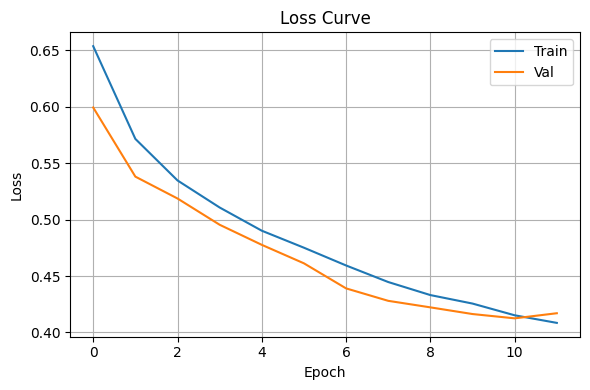

In [ ]:
def plot_loss(history):
    # check rapido per evitare altri errori silenziosi
    if not isinstance(history, dict) or "train" not in history or "val" not in history:
        raise ValueError(f"history malformato: attese chiavi ['train','val'], trovate {list(history.keys()) if isinstance(history, dict) else type(history)}")

    plt.figure(figsize=(6,4))
    plt.plot(history["train"], label="Train")
    plt.plot(history["val"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plot_loss(history)

[VAL] temperatura ottima T=0.833
[VAL] target=balanced_accuracy (beta=1.1) → t*=0.57 | bal_acc=0.816 | f1_macro=0.805


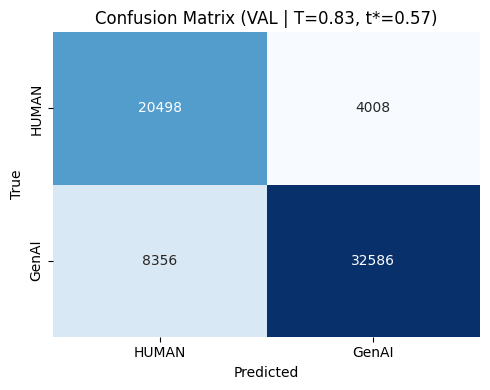

[LOG] Validation su en_val_holdout_sub25.csv — campioni: 65448
Accuracy: 0.8111 | F1 macro: 0.8044 | Precision macro: 0.8004 | Recall macro: 0.8162


In [ ]:
# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))   # in AMP
            labels_list.append(by.to(device))

    # Porta i logits a FP32 per stabilità della CE
    logits = torch.cat(logits_list).float()
    labels = torch.cat(labels_list)

    nll  = nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    opt  = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        opt.zero_grad()
        T = torch.exp(logT)
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    opt.step(closure)
    T = torch.exp(logT).item()
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

# 2) TUNING SOGLIA SU VALIDATION (usa T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0,
                          metric="balanced_accuracy", beta=1.1):
    model.eval()
    y_true, y_prob = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature
            p1 = torch.softmax(logits, dim=1)[:, 1].float().cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())

    y_true = np.array(y_true); y_prob = np.array(y_prob)

    def score(y_hat):
        if metric == "balanced_accuracy":
            return balanced_accuracy_score(y_true, y_hat)
        if metric == "f1_macro":
            return f1_score(y_true, y_hat, average="macro", zero_division=0)
        if metric == "precision_genai":
            p,_r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return p[1]
        if metric == "recall_genai":
            _p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            return r[1]
        if metric == "fbeta_genai":
            p,r,_f,_s = precision_recall_fscore_support(y_true, y_hat, labels=[0,1], average=None, zero_division=0)
            b2 = beta*beta
            return (1+b2)*p[1]*r[1]/max(1e-12, b2*p[1]+r[1])
        return balanced_accuracy_score(y_true, y_hat)

    best_t, best_s = 0.5, -1
    for t in np.linspace(0.45, 0.65, 41):
        s = score((y_prob >= t).astype(int))
        if s > best_s: best_s, best_t = s, t

    y_hat = (y_prob >= best_t).astype(int)
    print(f"[VAL] target={metric} (beta={beta}) → t*={best_t:.2f} | "
          f"bal_acc={balanced_accuracy_score(y_true,y_hat):.3f} | "
          f"f1_macro={f1_score(y_true,y_hat,average='macro',zero_division=0):.3f}")
    return best_t

# 3) Test finale (anche qui autocast per velocità su A100)
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()
    y_true, y_prob = [], []
    use_cuda = (device.type == "cuda")

    with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature
            p1 = torch.softmax(logits, dim=1)[:, 1].float().cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[TEST] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")

    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["HUMAN","GenAI"], yticklabels=["HUMAN","GenAI"])
    plt.xlabel("Pred"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """Valuta un loader: opzionale temperature scaling (softmax(logits/T)) e soglia custom.
    threshold=None → argmax a C classi; threshold=float → binarizza su p(y=1) >= threshold.
    Ritorna: (classification_report as dict, confusion_matrix as ndarray)."""
    model.eval()                                                #Modalità eval: no dropout/batchnorm update.
    y_true, y_pred = [], []                                     #Accumulatori etichette e predizioni.

    with torch.inference_mode():                                #Nessun grad/grafo --> più veloce e più leggero.
        for bx, by in loader:                                   #Itera su tutti i batch del loader.
            logits = model(bx.to(device)) / temperature         #Applica temperatura T (T=1 --> invariato).

            if threshold is None:
                #Multi-classe: prende l'argmax sui logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binario: probabilità della classe "1" (es. GenAI) e soglia.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            y_pred.extend(pred)                                 #Aggiunge predizioni del batch.
            y_true.extend(by.cpu().numpy())                     #Aggiunge etichette reali (CPU --> numpy).

    # METRICHE AGGREGGATE:
    #Forziamo l'ordine delle classi [0,1] per avere report/matrice consistenti.
    labels_fixed = [0, 1]
    report = classification_report(
        y_true, y_pred,
        labels=labels_fixed,                                    #Mostra sempre entrambe le classi.
        target_names=list(label_names),                         #Nomi umani per le classi.
        output_dict=True, digits=4,
        zero_division=0                                         #Evita warning se una classe è assente.
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)

    # PLOT DELLA CONFUSION MATRIX:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels,
                    cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


# Define evaluate_csv function within the cell
def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """Valuta direttamente un CSV:
    - costruisce TextDataset e DataLoader con **dynamic padding** via make_loader
    - applica evaluate_loader con temperature/soglia/plot.
    Ritorna: (report_dict, cm_array, num_records)."""
    batch_size = batch_size or global_var["batch_size"]               #Fallback alla config globale.
    ds = TextDataset(csv_path, vocab=vocab)                           #Dataset testuale (testo-->tensori via vocab).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)        #Dynamic padding per batch compatto.

    rep, cm = evaluate_loader(model, dl, label_names=label_names,
                              temperature=temperature, threshold=threshold,
                              plot_cm=plot_cm, title_suffix=title_suffix)
    return rep, cm, len(ds)

# Now call the functions
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device,
                               temperature=T, metric="balanced_accuracy", beta=1.1)

# report/CM sulla validation (utile per il controllo, come nella tua 2ª immagine)
rep_val, cm_val, n_val = evaluate_csv(
    model, VAL_SUB25_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star, plot_cm=True,
    title_suffix=f"(VAL | T={T:.2f}, t*={t_star:.2f})"
)
print(f"[LOG] Validation su {os.path.basename(VAL_SUB25_CSV)} — campioni: {n_val}")
print(f"Accuracy: {rep_val['accuracy']:.4f} | F1 macro: {rep_val['macro avg']['f1-score']:.4f} "
      f"| Precision macro: {rep_val['macro avg']['precision']:.4f} | Recall macro: {rep_val['macro avg']['recall']:.4f}")

# Quick predition

Questo blocco fa tre cose:

1. **Imposta** il percorso base su Drive e lo **crea** se manca.
2. Definisce un **alias di sicurezza** per `val_loader` (se non esiste, usa `test_loader`, così le utility di calibrazione non falliscono).
3. Implementa un **recupero resiliente** del vocabolario usato nel training (`base_vocab`), risalendo **ricorsivamente** attraverso container tipici di PyTorch (es. `Subset`, `DataLoader --> .dataset --> …`) finché trova un attributo `vocab`. Se non lo trova:
   - prova vari **candidati globali** in ordine di probabilità;
   - usa `vocab` **globale** se presente;
   - come **ultimo fallback** lo **ricostruisce** da `TRAIN_CSV` (non ideale perché potrebbe includere righe non usate dopo lo split).


**Complessità:** tempo $\mathcal{O}(\text{profondità della catena})$, memoria $\mathcal{O}(1)$.

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"        #Percorso base di lavoro su Google Drive.
os.makedirs(BASE, exist_ok=True)                                #Crea la directory se non esiste (idempotente).

#Se non è stato definito val_loader nel notebook, usa il test_loader come validation.
try:
    val_loader                                                 #Prova ad accedere al nome: se non esiste lancia NameError.
except NameError:
    val_loader = test_loader                                   #Fallback sicuro: evita crash nelle funzioni che richiedono VAL.

def extract_vocab(obj):
    """
    Restituisce obj.vocab se esiste; se obj è un Subset o un DataLoader,
    scende ricorsivamente in .dataset finché trova 'vocab'.
    """
    seen = set()                                               #Set di id() per evitare cicli (es. riferimenti ricorsivi).
    while obj is not None and id(obj) not in seen:             #Cammina finché c'è un oggetto nuovo nella catena.
        seen.add(id(obj))                                      #Marca l'oggetto corrente come visitato.
        if hasattr(obj, "vocab"):                              #Caso base: l'oggetto espone direttamente il vocabolario.
            return obj.vocab
        obj = getattr(obj, "dataset", None)                    #Altrimenti scendi in .dataset (Subset/DataLoader/...).
    return None                                                #Se non trovato, segnala fallimento.

#Prova a prendere il vocab da sorgenti note (in ordine di probabilità).
base_vocab = None
for cand in [
    globals().get("train_dataset", None),             #Può essere Subset --> ha .dataset interno.
    globals().get("full_train", None),                #Istanza completa del dataset di train.
    globals().get("train_ds", None),                  #Eventuale alias usato altrove.
    globals().get("train_loader", None),              #DataLoader: si scende in .dataset.
]:
    base_vocab = extract_vocab(cand)                  #Tenta l'estrazione ricorsiva.
    if base_vocab is not None:
        break                                         #Appena trovato, interrompi la ricerca.

#Fallback: usa 'vocab' globale se esiste.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab                                #Riutilizza il mapping già in memoria.

#Ultimo fallback: ricostruisce dal TRAIN_CSV (non ideale ma funziona)
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Non trovo il vocab del training; lo ricostruisco dal TRAIN_CSV (non ideale).")
    base_vocab = TextDataset(TRAIN_CSV).vocab         #Ricostruzione completa.

if base_vocab is None:
    raise RuntimeError(
        "Impossibile recuperare il vocabolario del training. "
        "Assicurati che 'train_dataset' (o 'train_loader') sia in memoria, "
        "oppure definisci una variabile globale 'vocab' con il mapping token→id."
    )

print(f"[LOG] Vocab recuperato correttamente (size={len(base_vocab):,}).")  #Esito positivo con dimensione formattata.

[LOG] Vocab recuperato correttamente (size=277,165).


Queste utility valutano il classificatore su un **DataLoader** o direttamente da **CSV** (con **dynamic padding**).  
Con logits $z\in\mathbb{R}^{B\times K}$ e temperatura $T>0$, le probabilità sono:
$$
p=\mathrm{softmax}\!\left(\frac{z}{T}\right),\qquad
p_{i,c}=\frac{e^{z_{i,c}/T}}{\sum_{j} e^{z_{i,j}/T}}.
$$

**Decisione:**
- senza soglia: $\;\hat y_i=\arg\max\limits_{c}\; z_{i,c}$  
- con soglia $t$ (binaria, classe 1): $\;\hat y_i=\mathbf{1}[\,p_{i,1}\ge t\,]$

Si computano il **classification report** (precision/recall/F1 per classe e aggregati) e la **confusion matrix**; facoltativamente si visualizza la **heatmap**.  
`evaluate_csv` costruisce un `TextDataset` da `csv_path`, crea il `DataLoader` con `make_loader` (--> *dynamic padding*) e richiama `evaluate_loader`.

In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """Valuta un loader: opzionale temperature scaling (softmax(logits/T)) e soglia custom.
    threshold=None → argmax a C classi; threshold=float → binarizza su p(y=1) >= threshold.
    Ritorna: (classification_report as dict, confusion_matrix as ndarray)."""
    model.eval()                                                #Modalità eval: no dropout/batchnorm update.
    y_true, y_pred = [], []                                     #Accumulatori etichette e predizioni.

    with torch.inference_mode():                                #Nessun grad/grafo --> più veloce e più leggero.
        for bx, by in loader:                                   #Itera su tutti i batch del loader.
            logits = model(bx.to(device)) / temperature         #Applica temperatura T (T=1 --> invariato).

            if threshold is None:
                #Multi-classe: prende l'argmax sui logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binario: probabilità della classe "1" (es. GenAI) e soglia.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            y_pred.extend(pred)                                 #Aggiunge predizioni del batch.
            y_true.extend(by.cpu().numpy())                     #Aggiunge etichette reali (CPU --> numpy).

    # METRICHE AGGREGGATE:
    #Forziamo l'ordine delle classi [0,1] per avere report/matrice consistenti.
    labels_fixed = [0, 1]
    report = classification_report(
        y_true, y_pred,
        labels=labels_fixed,                                    #Mostra sempre entrambe le classi.
        target_names=list(label_names),                         #Nomi umani per le classi.
        output_dict=True, digits=4,
        zero_division=0                                         #Evita warning se una classe è assente.
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)

    # PLOT DELLA CONFUSION MATRIX:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels,
                    cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """Valuta direttamente un CSV:
    - costruisce TextDataset e DataLoader con **dynamic padding** via make_loader
    - applica evaluate_loader con temperature/soglia/plot.
    Ritorna: (report_dict, cm_array, num_records)."""
    batch_size = batch_size or global_var["batch_size"]               #Fallback alla config globale.
    ds = TextDataset(csv_path, vocab=vocab)                           #Dataset testuale (testo-->tensori via vocab).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)        #Dynamic padding per batch compatto.

    rep, cm = evaluate_loader(model, dl, label_names=label_names,
                              temperature=temperature, threshold=threshold,
                              plot_cm=plot_cm, title_suffix=title_suffix)
    return rep, cm, len(ds)

Questo blocco crea un **mini–dataset di evaluation** (30 righe bilanciate per *topic* e *classe*: $0=\text{HUMAN}$, $1=\text{GenAI}$), lo **salva** in CSV, mostra una **diagnostica rapida** delle distribuzioni, poi esegue la **calibrazione** delle probabilità via *temperature scaling* (stima di $T>0$ su validation), il **tuning** di una **soglia di decisione** $t^*$ su validation (massimizzando *balanced accuracy* o *macro–F1*), e infine la **valutazione completa** sul CSV appena creato (con **confusion matrix** in heatmap e **metriche macro**).

Formalmente, date le logit $z\in\mathbb{R}^K$, si calibra:
$$
p_c(T)=\frac{e^{z_c/T}}{\sum_{j=1}^{K} e^{z_j/T}},
$$

e in binario si decide:
$$
\hat y=\mathbf{1}\!\left[p_1(T)\ge t^*\right].
$$

La scelta di $T$ **minimizza** la NLL su validation; $t^*$ **massimizza** la metrica scelta su validation.  
Il report finale mostra **Accuracy**, **F1 macro**, **Precision macro** e **Recall macro**.

[LOG] VALIDATION: /content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout_sub25.csv (65448 righe)
[LOG] Distribuzione label:
label
0    24506
1    40942
[VAL] temperatura ottima T=0.833
[VAL] target=balanced_accuracy (beta=1.1) → t*=0.57 | bal_acc=0.816 | f1_macro=0.805


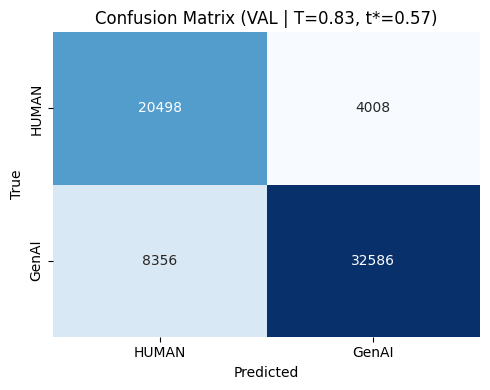


[LOG] Evaluation su VALIDATION — campioni: 65448
Accuracy: 0.8111  |  F1 macro: 0.8044  |  Precision macro: 0.8004  |  Recall macro: 0.8162


In [ ]:
# Valutazione su VALIDATION (lo stesso split usato per calibrare T e t*)
EVAL_CSV = VAL_CSV_PATH
df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] VALIDATION: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# Calibrazione e tuning SU validation
T = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device, temperature=T, metric="balanced_accuracy")

# Valutazione su validation (coerente con T e t*)
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix=f"(VAL | T={T:.2f}, t*={t_star:.2f})"
)
assert cm_eval.sum() == n_eval, f"Non ho visto tutta la VALIDATION: {cm_eval.sum()}/{n_eval}"

print(f"\n[LOG] Evaluation su VALIDATION — campioni: {n_eval}")
if 'macro avg' in rep_eval:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
          f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")
else:
    print(f"Accuracy: {rep_eval['accuracy']:.4f}")

Questo blocco costruisce un **tabellone di evaluation**: legge il CSV creato in precedenza, esegue **inference** con *temperature scaling* $T_{\text{eval}}$ e **soglia** $t_{\text{eval}}$, aggrega **probabilità**, **predizioni**, **etichette vere**, e produce una **tabella ordinata** (errori in alto) oltre a salvare un CSV completo su Drive.

- **Rilevamento BASE:** se la variabile non esiste, prova due path noti su Drive e prende il primo che trova.
- **Caricamento eval:** `TextDataset(EVAL_CSV, vocab=full_train.vocab)` garantisce che gli ID token siano **coerenti** con il training.
- **Inference:** per ogni batch, calcola
$$
p_{1}=\big(\mathrm{softmax}(z/T_{\text{eval}})\big)_{c=1},
\qquad
\hat y=\mathbf{1}\!\left[p_{1}\ge t_{\text{eval}}\right],
$$
  dove $p_{1}$ è la probabilità della classe *GenAI*.
- **Output tabellare:** costruisce un `DataFrame` con colonne testuali e numeriche, mappa gli ID a stringhe (*HUMAN/GenAI*), aggiunge un flag **✓/✗** e **ordina** portando in testa gli errori.
- **Visualizzazione & salvataggio:** mostra a schermo le **prime 30 righe** e salva **tutto** in un CSV versionato con $T_{\text{eval}}$ e $t_{\text{eval}}$ nel nome. Un secondo riquadro opzionale mostra **solo gli errori**.

[TEST] acc=0.850  prec=0.971  rec=0.810  f1_bin=0.883  f1_macro=0.837  bal_acc=0.877

              precision    recall  f1-score   support

           0      0.680     0.944     0.791        18
           1      0.971     0.810     0.883        42

    accuracy                          0.850        60
   macro avg      0.826     0.877     0.837        60
weighted avg      0.884     0.850     0.855        60



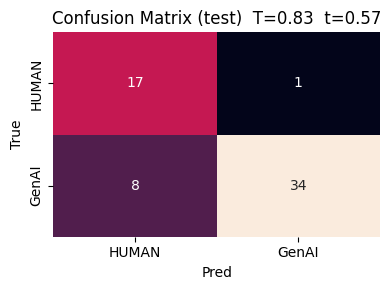

,id,text,true,pred,prob_genai_it,correct
7,026b8a68-9a06-450d-bf45-1b8ff4c2691f,Carpet-weaving is historically a major traditi...,HUMAN,GenAI,"67,99%",✗
21,eed666c5-1f9e-4858-9f35-15f4606d3644,Fiction merely provides entertainment. It does...,GenAI,HUMAN,"50,70%",✗
41,9785b35f-4473-4ddc-b09b-a93a24a85369,Jack and Tom were friends for more than fiftee...,GenAI,HUMAN,"49,37%",✗
24,17384c3e-d34f-478f-b69d-c2e54a109553,"Sure! So when we say that a drink is ""100 proo...",GenAI,HUMAN,"39,82%",✗
48,73a98f93-2870-4489-b8e1-52d79d01f810,"Once upon a midnight dreary, while I pondered,...",GenAI,HUMAN,"37,78%",✗
17,abd9f5c2-197e-430c-83a4-fc0af5b8bd51,This is a view I've read about from various po...,GenAI,HUMAN,"28,65%",✗
25,29e0932b-8097-400c-a96f-7b2c6bc96d8d,"In this paper, network of agents with identica...",GenAI,HUMAN,"15,94%",✗
39,957421f3-5b8f-475e-a9a2-ba1bbd78b96b,"ring-ring [ obstacleObject (classification, di...",GenAI,HUMAN,"14,42%",✗
4,ca011877-685b-418e-9a48-3be3627c6610,throw the grass they cut back behind them. the...,GenAI,HUMAN,"3,24%",✗
57,74874dbf-e511-4d9b-a0e3-9234d232ef90,We investigate the long-term optical spectral ...,GenAI,GenAI,"99,74%",✓


[LOG] File predizioni TEST (60) salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_EN_fixed_T0.83_t0.57.csv
[LOG] Righe salvate: 60 (atteso 60)


In [ ]:
# Valutazione complessiva su TEST (60) – come nella 1ª immagine
evaluate_on_test_with_threshold(model, test_loader, device, t_star, temperature=T)

# Tabella predizioni dettagliate (con percentuali) SOLO per le 60 righe
df_src = pd.read_csv(TEST_CSV)
model.eval(); probs = []; preds = []
with torch.inference_mode():
    for bx, _ in test_loader:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())

out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
lab = {0:"HUMAN",1:"GenAI"}
out["true"] = out["true_id"].map(lab)
out["pred"] = out["pred_id"].map(lab)
out["prob_genai_pct"] = (out["prob_genai"]*100.0).round(2)         # percentuali richieste
out["prob_genai_it"]  = out["prob_genai_pct"].map(lambda x: f"{x:.2f}%".replace('.',','))  #  es. "87,45%"

# Ordina: prima errori, poi probabilità decrescente
out["correct"] = np.where(out["true_id"]==out["pred_id"], "✓", "✗")
view = out.copy()
view["err_rank"] = (view["correct"]=="✓").astype(int)
view = view.sort_values(["err_rank","prob_genai"], ascending=[True,False]).drop(columns=["err_rank"])

# Mostra e salva
cols = [c for c in ["id","topic"] if c in view.columns] + ["text","true","pred","prob_genai_it","correct"]
display(view[cols].head(30))

fname = f"predictions_TEST_EN_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
# salviamo anche la colonna percentuale “umana”
view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST (60) salvato in:", save_path)
print(f"[LOG] Righe salvate: {len(view)} (atteso 60)")

In [ ]:
# Se BASE non è definito, prova a rilevarlo
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p; break

# Usa il TEST fisso
TEST_CSV_PATH = TEST_CSV if 'TEST_CSV' in globals() else f"{BASE}/en_test_fixed.csv"
assert os.path.exists(TEST_CSV_PATH), f"File non trovato: {TEST_CSV_PATH}"

# Loader sul TEST con il vocab del TRAIN
_vocab = full_train.vocab if 'full_train' in globals() else vocab
test_ds = TextDataset(TEST_CSV_PATH, vocab=_vocab)
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

# Inference: probabilità GenAI e pred binaria con t_star e temperatura T
probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        logits = model(bx.to(device)) / T
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_star).astype(int).tolist())

# Tabella risultati
df_src = pd.read_csv(TEST_CSV_PATH)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

# Ordina: errori prima, poi probabilità decrescente
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# Mostra estratto
pd.set_option("display.max_colwidth", 160)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai","correct"]
print("[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# Salva con T e t*
fname = f"predictions_EN_TEST_fixed_T{T:.2f}_t{t_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# Solo errori
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai,correct
7,026b8a68-9a06-450d-bf45-1b8ff4c2691f,"Carpet-weaving is historically a major traditional profession for the majority of Armenian women, including many Armenian families. Prominent Karabakh carpe...",HUMAN,GenAI,0.679922,✗
21,eed666c5-1f9e-4858-9f35-15f4606d3644,"Fiction merely provides entertainment. It doesn't help us grow at all. There are other sources of information that help us grow much better. If that is so, ...",GenAI,HUMAN,0.507001,✗
41,9785b35f-4473-4ddc-b09b-a93a24a85369,Jack and Tom were friends for more than fifteen years. They met in college and shared the same interest in politics. They spent countless hours discussing p...,GenAI,HUMAN,0.493712,✗
24,17384c3e-d34f-478f-b69d-c2e54a109553,"Sure! So when we say that a drink is ""100 proof,"" that means it is 50% alcohol by volume. The other 50% of the liquid is made up of water and other ingredie...",GenAI,HUMAN,0.398219,✗
48,73a98f93-2870-4489-b8e1-52d79d01f810,"Once upon a midnight dreary, while I pondered, weak and tired, Over many a quaint and curious volume of forgotten lore - While I nodded, nearly falling asle...",GenAI,HUMAN,0.377752,✗
17,abd9f5c2-197e-430c-83a4-fc0af5b8bd51,"This is a view I've read about from various pop psychology sources, and it has become conventional wisdom. I believe it contains some truth. Can you convinc...",GenAI,HUMAN,0.286540,✗
25,29e0932b-8097-400c-a96f-7b2c6bc96d8d,"In this paper, network of agents with identical dynamics is considered. The agents are assumed to be fed by self and neighboring output measurements, while ...",GenAI,HUMAN,0.159389,✗
39,957421f3-5b8f-475e-a9a2-ba1bbd78b96b,"ring-ring [ obstacleObject (classification, distance) classification human (s) distance 800m run eSTOP DangerException: Action unsuccessful run emergencyReR...",GenAI,HUMAN,0.144218,✗
4,ca011877-685b-418e-9a48-3be3627c6610,throw the grass they cut back behind them. they kick it over the fence.,GenAI,HUMAN,0.032418,✗
57,74874dbf-e511-4d9b-a0e3-9234d232ef90,"We investigate the long-term optical spectral variability of BL Lacertae, a prototype of blazars, to probe the underlying physical mechanisms driving the ob...",GenAI,GenAI,0.997429,✓


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_EN_TEST_fixed_T0.83_t0.57.csv

[INFO] Errori totali: 9



,id,text,true,pred,prob_genai,correct
7,026b8a68-9a06-450d-bf45-1b8ff4c2691f,"Carpet-weaving is historically a major traditional profession for the majority of Armenian women, including many Armenian families. Prominent Karabakh carpe...",HUMAN,GenAI,0.679922,✗
21,eed666c5-1f9e-4858-9f35-15f4606d3644,"Fiction merely provides entertainment. It doesn't help us grow at all. There are other sources of information that help us grow much better. If that is so, ...",GenAI,HUMAN,0.507001,✗
41,9785b35f-4473-4ddc-b09b-a93a24a85369,Jack and Tom were friends for more than fifteen years. They met in college and shared the same interest in politics. They spent countless hours discussing p...,GenAI,HUMAN,0.493712,✗
24,17384c3e-d34f-478f-b69d-c2e54a109553,"Sure! So when we say that a drink is ""100 proof,"" that means it is 50% alcohol by volume. The other 50% of the liquid is made up of water and other ingredie...",GenAI,HUMAN,0.398219,✗
48,73a98f93-2870-4489-b8e1-52d79d01f810,"Once upon a midnight dreary, while I pondered, weak and tired, Over many a quaint and curious volume of forgotten lore - While I nodded, nearly falling asle...",GenAI,HUMAN,0.377752,✗
17,abd9f5c2-197e-430c-83a4-fc0af5b8bd51,"This is a view I've read about from various pop psychology sources, and it has become conventional wisdom. I believe it contains some truth. Can you convinc...",GenAI,HUMAN,0.286540,✗
25,29e0932b-8097-400c-a96f-7b2c6bc96d8d,"In this paper, network of agents with identical dynamics is considered. The agents are assumed to be fed by self and neighboring output measurements, while ...",GenAI,HUMAN,0.159389,✗
39,957421f3-5b8f-475e-a9a2-ba1bbd78b96b,"ring-ring [ obstacleObject (classification, distance) classification human (s) distance 800m run eSTOP DangerException: Action unsuccessful run emergencyReR...",GenAI,HUMAN,0.144218,✗
4,ca011877-685b-418e-9a48-3be3627c6610,throw the grass they cut back behind them. they kick it over the fence.,GenAI,HUMAN,0.032418,✗
